In [5]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pickle

from glob import glob
from itertools import product
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from find import *
from classifier import *

usage: __main__.py [-h] [--retrain] [--nbtrain NBTRAIN] [--video VIDEO]
__main__.py: error: unrecognized arguments: -f /run/user/1000/jupyter/kernel-d8b51117-abff-4893-b787-56839a2534ad.json


SystemExit: 2

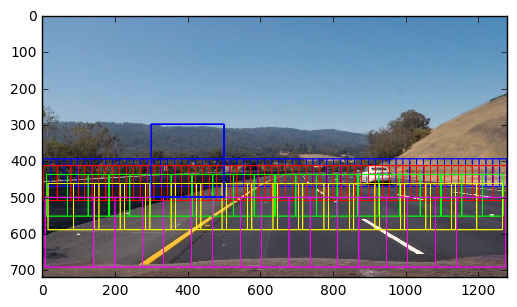

In [18]:
def box_generator(yoi, xoi, yd_ratio = 0.20, scales = [1.2,1.5,1.8,2.0,3.0], xover = 0.9, window = 64):
    """
    a windows generator that gives a the searching strategy
    """
    width = xoi[1] - xoi[0]

    sizes = (np.array(scales)*window).astype(int)
    xsteps = (sizes*(1 - 1/np.array(scales)*xover)).astype(int)
    ydists = np.cumsum((yd_ratio*sizes).astype(int)) + yoi[0]
    begins = (width - sizes) % xsteps // 2
    nbs = (width - sizes) // xsteps + 1

    xleft = [xsteps[i]*np.arange(nbs[i]) + begins[i] for i in range(len(scales))]
    xright = [xleft[i] + sizes[i] for i in range(len(scales))]
    ytop = [np.ones(nbs[i], dtype = int)*ydists[i] for i in range(len(scales))]
    ybtm = [ytop[i] + sizes[i] for i in range(len(scales))]

    wins = [np.vstack([xleft[i], ytop[i], xright[i],ybtm[i]]).T.reshape([-1, 2, 2]) for i in range(len(scales))]

    wins_scaled = []
    for i in range(len(scales)):
        a = wins[i][:,0]/scales[i]
        wins_scaled.append(np.hstack([a, a + window]).reshape((-1, 2, 2)).astype(int))

    return scales, wins, wins_scaled


def infected_window(window, bias = 20, scales = [1, 1.2]):
    side = window[1][1] - window[0][1]
    bs = [bias, -bias, 0]
    scheme = [np.repeat(list(product(bs, bs))[:-1],2,0).reshape(-1,2,2) for scl in scales]
    ss = [np.repeat([int(scl*side)], 8, 0) for scl in scales]
    diffs = [(s-side)//2 for s in ss]
    x_as = [window[0][0] - diff for diff in diffs]
    y_as = [window[0][1] - diff for diff in diffs]
    x_bs = [x_as[i] + s for i, s in enumerate(ss)]
    y_bs = [y_as[i] + s for i, s in enumerate(ss)]
    wins = [np.vstack([x_as[i], y_as[i], x_bs[i], y_bs[i]]).T.reshape((-1,2,2)) + scheme[i]
            for i in range(len(scales))]
    wins_scaled = [(wins[i]/scales[i]).astype(int) for i in range(len(scales))]
    return scales, wins, wins_scaled

infected = infected_window([[70, 240], [70, 240]])

scales, windows, windows_scaled = box_generator((380, 700), (0, 1280))


img = cv2.cvtColor(cv2.imread('./test_images/test3.jpg'), cv2.COLOR_BGR2RGB)
color = [[0, 0, 255], [255, 0, 0], [0, 255, 0], [255, 255, 0], [255, 0, 255], [0, 255, 255], [0, 0, 127]]
i = 0
s = 0
for wins in windows:
    s += len(windows)
    for win in wins:
        cv2.rectangle(img, tuple(win[0]), tuple(win[1]), color = color[i], thickness = 2)
    i = i + 1
cv2.rectangle(img, (300, 300), (500, 500), color = color[0], thickness = 3)
# for win in infected:
#     cv2.rectangle(img, tuple(win[0]), tuple(win[1]), color = color[0], thickness = 3)
plt.imshow(img)
plt.show()

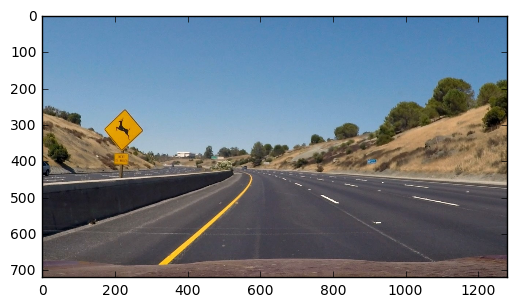

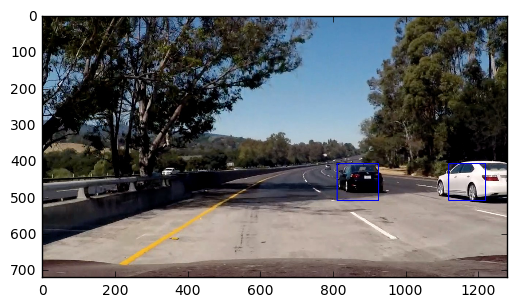

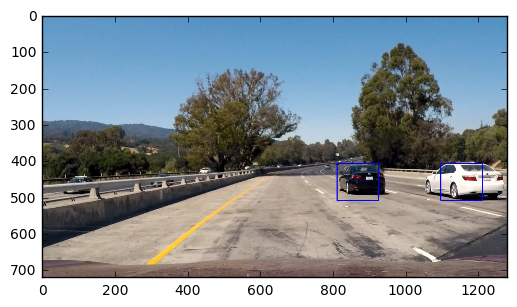

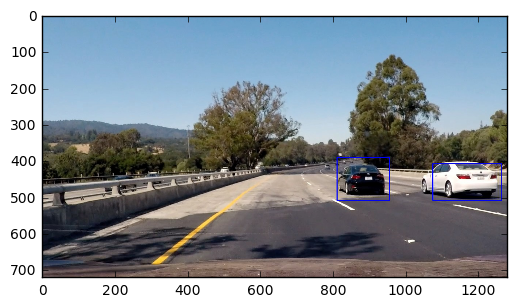

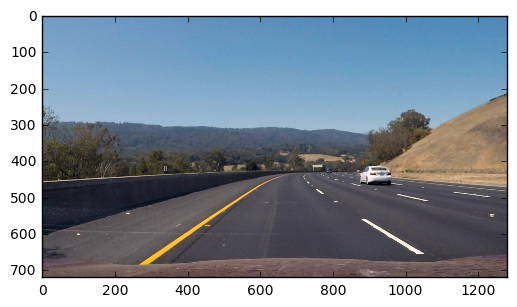

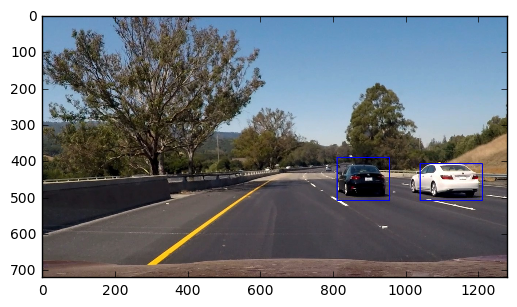

In [21]:
for f in glob('./output_images/**.jpg'):
    plt.imshow(cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB))
    plt.show()

In [ ]:
test()
with open('clf.pickle', 'rb') as f:
    clf, scaler = pickle.load(f)
pos = [(360, 700, 1.5)]
detector = car_detector('YCrCb', pos, clf, scaler, 8, 8, 2, 0)
video = VideoFileClip('./project_video.mp4')
video = video.fl_image(detector.find)
%time video.write_videofile('test.mp4', audio = False)